In [ ]:
import matplotlib
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from IPython.display import HTML
import gymnasium as gym
import numpy as np
import copy
import random
import torch.nn.functional as F

In [ ]:
def seed_everything(
    env: gym.Env,
    seed: int = 42,
    *,
    torch_deterministic: bool = True
) -> None:
    # 1. Seed the environment (Gymnasium way)
    env.reset(seed=seed)

    # 2. Seed the spaces (for .sample())
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    # 3. Seed NumPy
    np.random.seed(seed)

    # 4. Seed PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

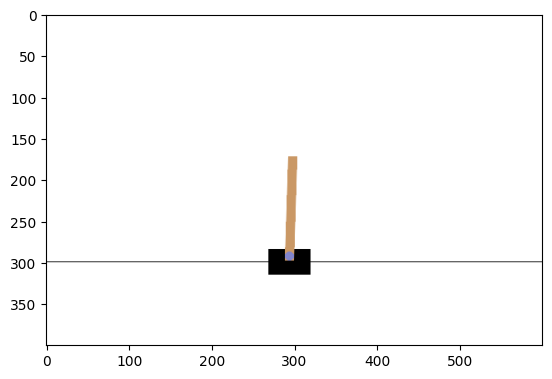

In [ ]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
seed_everything(env)
env.reset()
frame = env.render()
plt.imshow(frame)

In [ ]:
class makeTorchCompatible(gym.Wrapper):
  def __init__(self,env):
    gym.Wrapper.__init__(self,env)

  def reset(self):
    state , _ = self.env.reset()
    state = torch.tensor(state.reshape((1,self.env.observation_space.shape[0])))
    return state
    #  return torch.from_numpy(state).unsqueeze(dim=0).float()

  def step(self,action):
    action = action.item()
    state , reward , terminated , truncated , _ = self.env.step(action)
    state = torch.tensor(state.reshape((1,self.env.observation_space.shape[0])))
    reward = torch.tensor(reward).view(1, -1).float()
    truncated = torch.tensor(truncated).view(1, -1)
    terminated = torch.tensor(terminated).view(1,-1)
    return state , reward , terminated , truncated





In [ ]:
env = makeTorchCompatible(env)

In [ ]:
class ReplayBuffer():

  def __init__(self,capacity):
    self.capacity = capacity
    self.memoryBuffer = []
    self.index = 0

  def networkStartsLearning(self,batchSize):
    return True if (len(self.memoryBuffer) > (10*batchSize)) else False

  def addTransition(self,transition):
    if (len(self.memoryBuffer) < self.capacity):
      self.memoryBuffer.append(None)
    self.memoryBuffer[self.index] = transition
    self.index = (self.index + 1) % self.capacity

  def organizeTransitions(self,batchSize):
    if (self.networkStartsLearning(batchSize)):
      learning_samples = random.sample(self.memoryBuffer,batchSize)
      learning_samples = zip(*learning_samples)
      return [torch.cat(items) for items in learning_samples]


    else:
      raise RuntimeError("Not enough samples in memeory to start learning")

  def returnLength(self):
     return len(self.memoryBuffer)

  def clearTransitions(self):
    self.memoryBuffer = []
    self.index = 0




In [ ]:
def policy(DQN,state,epsilon = 0):
  random_value = np.random.random()
  if random_value < epsilon:

    return torch.tensor(np.random.randint(env.action_space.n)).unsqueeze(0).unsqueeze(0)

  else:
    return torch.argmax(DQN(state).detach() , keepdim = True)

In [ ]:
def createNetwork(i):

  DQN = nn.Sequential(
    nn.Linear(env.observation_space.shape[0],i),
    nn.ReLU(),
    nn.Linear(i,i//2),
    nn.ReLU(),
    nn.Linear(i//2,env.action_space.n))

  copy_network = copy.deepcopy(DQN).eval()
  return DQN,copy_network







In [ ]:
#copy_network = copy.deepcopy(createNetwork(i)).eval()

In [ ]:

def deepQLearning(policy,episodes,discountFactor=0.99,epsilon = 0.2,alpha = 0.0001,batchSize = 32):

  ReturnPerEpisode = {0:[] , 1 : [] , 2 : []}

  NeuronValues = [512,256,128]
  memory = ReplayBuffer(1000000)

  for index,value in enumerate(NeuronValues):
    DQN,copy_network = createNetwork(value)
    optimizer = torch.optim.AdamW(DQN.parameters(),lr = alpha)
    for episode in tqdm(range(1,episodes+1)):
      state = env.reset()
      truncated = False
      terminated = False
      return_episode = 0
      done = False
      while(done == False):

        action = policy(DQN,state,epsilon)
        next_state , reward , terminated , truncated = env.step(action)
        if terminated.item() == True or truncated.item() == True:
          done = True
        else:
          done = False
        memory.addTransition([state,action,reward,torch.tensor(done).unsqueeze(0).unsqueeze(0),next_state])

        if memory.networkStartsLearning(batchSize):
          states,actions,returns,done_values,next_states = memory.organizeTransitions(batchSize)
          action_values = DQN(states).gather(1,actions)
          action_values_succedingStates = copy_network(next_states).max(dim = -1 ,keepdim = True)[0]
          target_values = returns + ~done_values * discountFactor*action_values_succedingStates
          loss = F.mse_loss(action_values,target_values)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          #MSE_Error.append(loss.item())

        return_episode = return_episode + reward.item()
        state = next_state

      if episode % 10 == 0:
        copy_network.load_state_dict(DQN.state_dict())
      ReturnPerEpisode[index].append(return_episode)
  memory.clearTransitions()

  return ReturnPerEpisode

In [ ]:
ReturnPerEpisode = deepQLearning(policy,500)

100%|██████████| 500/500 [01:46<00:00,  4.70it/s]


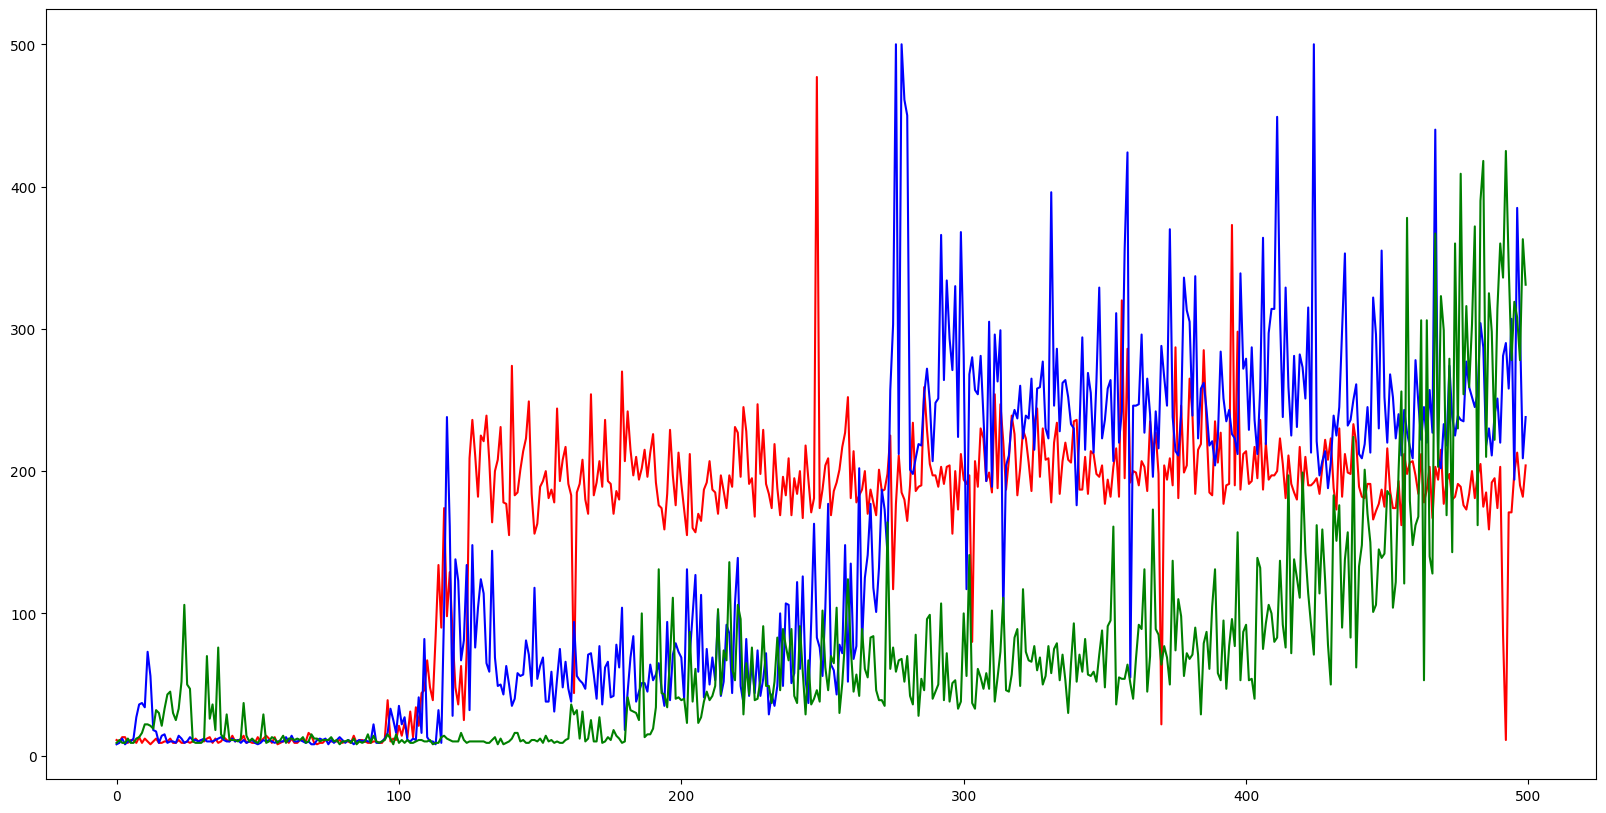

In [ ]:
from IPython.core.pylabtools import figsize
fig,ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(ReturnPerEpisode[0],color = 'red')
ax.plot(ReturnPerEpisode[1],color = 'blue')
ax.plot(ReturnPerEpisode[2],color = 'green')



In [ ]:
# from matplotlib import animation
# def display_video(frames):
#     # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
#     orig_backend = matplotlib.get_backend()
#     matplotlib.use('Agg')
#     fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#     matplotlib.use(orig_backend)
#     ax.set_axis_off()
#     ax.set_aspect('equal')
#     ax.set_position([0, 0, 1, 1])
#     im = ax.imshow(frames[0])
#     def update(frame):
#         im.set_data(frame)
#         return [im]
#     anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
#                                     interval=50, blit=True, repeat=False)
#     return HTML(anim.to_html5_video())


# def test_agent(env, policy, episodes=10):
#     frames = []
#     for episode in range(episodes):
#         state = env.reset()
#         done = False
#         frames.append(env.render(mode="rgb_array"))

#         while not done:
#             p = policy(state)
#             if isinstance(p, np.ndarray):
#                 action = np.random.choice(4, p=p)
#             else:
#                 action = p
#             next_state, reward, done, extra_info = env.step(action)
#             img = env.render(mode="rgb_array")
#             frames.append(img)
#             state = next_state

#     return display_video(frames)

In [ ]:
# test_agent(env, policy, episodes=2)

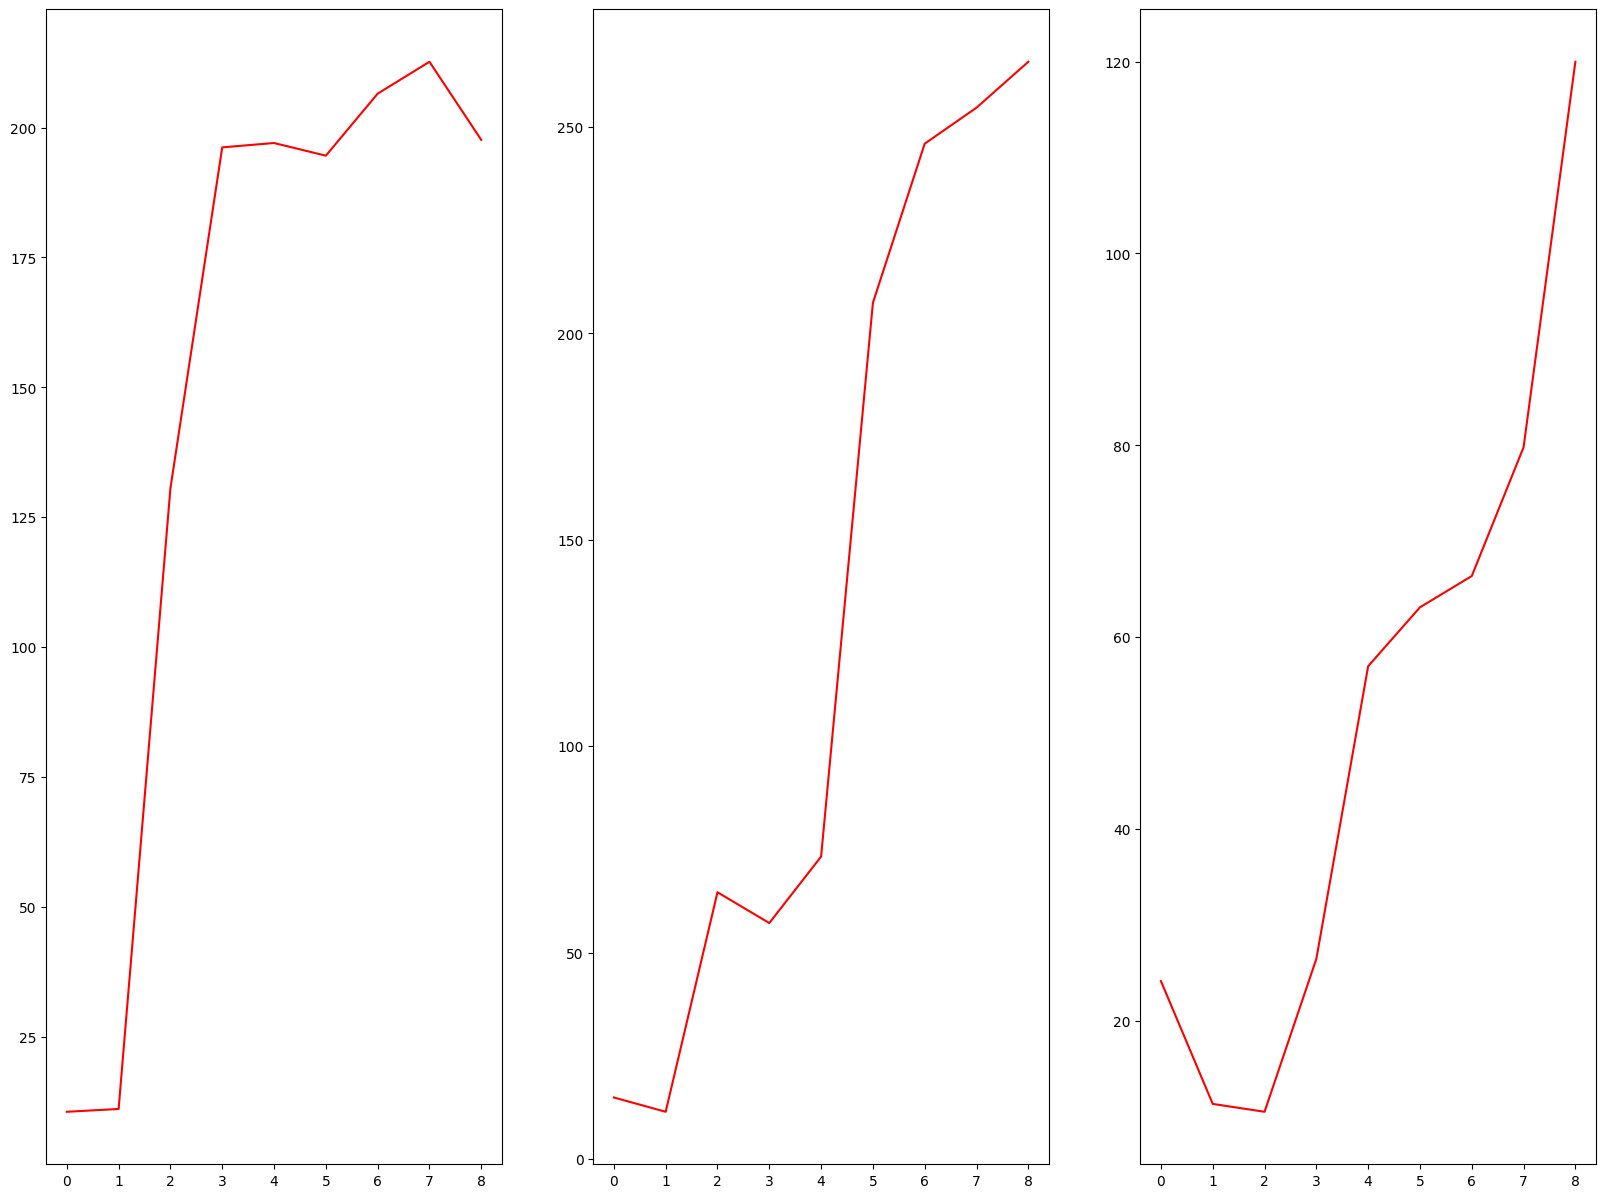

In [ ]:
fig,axes = plt.subplots(nrows = 1 , ncols = 3 , figsize= (20,15))

for column in range(0,3):
   mean_list = []
   for index in range(0,len(ReturnPerEpisode[column])):

         if(index % 50 == 0 and index != 0):
           mean_list.append(np.mean(ReturnPerEpisode[column][index-50:index]))

   axes[column].plot(mean_list,color = 'red')

The best average reward over the past 50 episodes is obtained when the hidden neurons are 256
